## Module 9 Lab: Numba Python

In [1]:
!nvidia-smi

Tue Apr 29 21:24:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.61                 Driver Version: 572.61         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   48C    P8              3W /   60W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [7]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2025 NVIDIA Corporation
Built on Fri_Feb_21_20:42:46_Pacific_Standard_Time_2025
Cuda compilation tools, release 12.8, V12.8.93
Build cuda_12.8.r12.8/compiler.35583870_0


## Problem 1 ImageBlur kernel from Lab4

c:\Users\Himanshu Gaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\cudadrv\devicearray.py:887: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


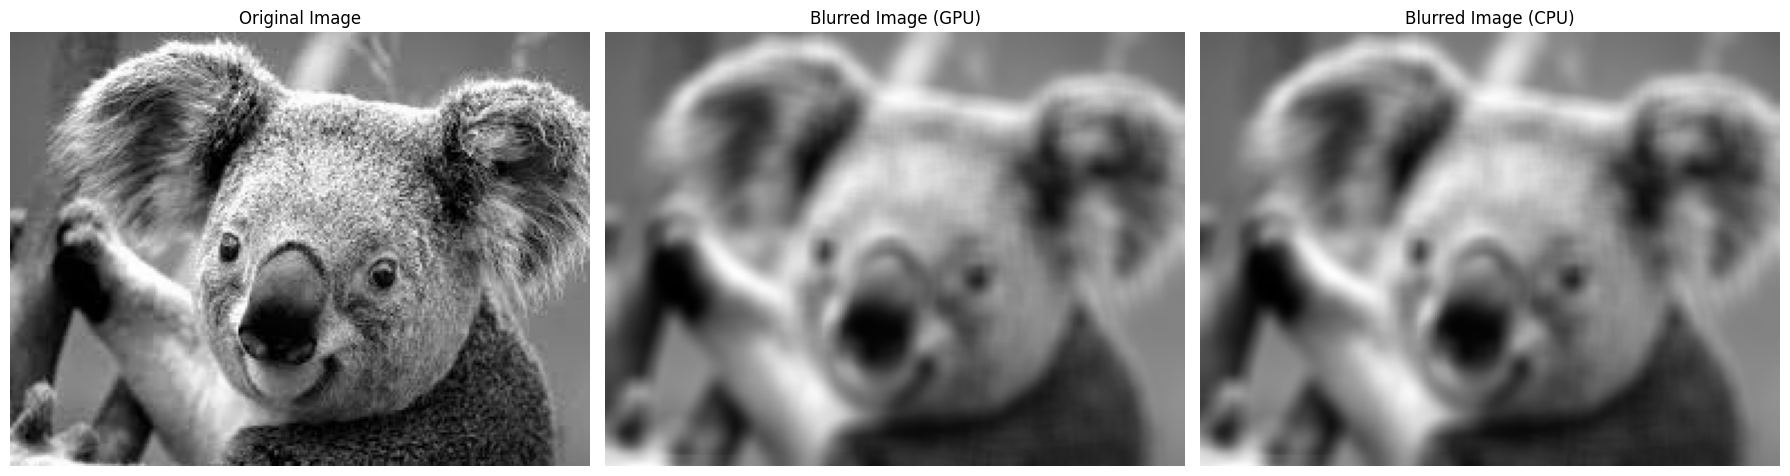

GPU Execution Time: 0.3511 seconds
CPU Execution Time: 2.3072 seconds
Comparison of GPU and CPU results: True
GPU speedup factor: 6.57x
Approximate FLOPS for GPU: 8139852
Approximate FLOPS for CPU: 8139852
GPU Performance: 0.02 GFLOPS
CPU Performance: 0.00 GFLOPS
GPU Memory Usage: 3459.67 MB
CPU Memory Usage: 0.05 MB
GPU Bandwidth: 9852.54 MB/s
CPU Bandwidth: 0.02 MB/s


In [4]:
import numpy as np
from numba import cuda
from PIL import Image
import matplotlib.pyplot as plt
import time
import math

def load_image(image_path):
    img = Image.open(image_path).convert('L')
    img_array = np.array(img)
    return img_array

def cpu_blur(input_image):
    height, width = input_image.shape
    output_image = np.zeros_like(input_image)
    for y in range(height):
        for x in range(width):
            pixel_value = 0
            count = 0
            for i in range(-4, 5):
                for j in range(-4, 5):
                    if 0 <= x + i < width and 0 <= y + j < height:
                        pixel_value += input_image[y + j, x + i]
                        count += 1
            output_image[y, x] = pixel_value // count
    return output_image

@cuda.jit
def blur_kernel(input_image, output_image):
    x, y = cuda.grid(2)
    height, width = input_image.shape
    if x < width and y < height:
        pixel_value = 0
        count = 0
        for i in range(-4, 5):
            for j in range(-4, 5):
                if 0 <= x + i < width and 0 <= y + j < height:
                    pixel_value += input_image[y + j, x + i]
                    count += 1
        output_image[y, x] = pixel_value // count

image_path = 'E:\\Intern\\MEGA-MINDS\\Assign 9\\sample_image3.jpg'
image = load_image(image_path)
output_image = np.zeros_like(image)

threads_per_block = (16, 16)
blocks_per_grid = (math.ceil(image.shape[1] / threads_per_block[0]), math.ceil(image.shape[0] / threads_per_block[1]))

start_gpu_time = time.time()
blur_kernel[blocks_per_grid, threads_per_block](image, output_image)
end_gpu_time = time.time()
gpu_time = end_gpu_time - start_gpu_time

start_cpu_time = time.time()
cpu_output = cpu_blur(image)
end_cpu_time = time.time()
cpu_time = end_cpu_time - start_cpu_time

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(output_image, cmap='gray')
axes[1].set_title("Blurred Image (GPU)")
axes[1].axis('off')

axes[2].imshow(cpu_output, cmap='gray')
axes[2].set_title("Blurred Image (CPU)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(f"GPU Execution Time: {gpu_time:.4f} seconds")
print(f"CPU Execution Time: {cpu_time:.4f} seconds")
print("Comparison of GPU and CPU results:", np.allclose(output_image, cpu_output))
print("GPU speedup factor: {:.2f}x".format(cpu_time / gpu_time))

image_size = image.size
flops_gpu = 2 * image_size * (9 * 9)
flops_cpu = flops_gpu

gpu_gflops = flops_gpu / (gpu_time * 1e9)
cpu_gflops = flops_cpu / (cpu_time * 1e9)

print(f"Approximate FLOPS for GPU: {flops_gpu}")
print(f"Approximate FLOPS for CPU: {flops_cpu}")
print(f"GPU Performance: {gpu_gflops:.2f} GFLOPS")
print(f"CPU Performance: {cpu_gflops:.2f} GFLOPS")

# Additional Performance Results
gpu_memory_usage = cuda.current_context().get_memory_info()[0]  # GPU memory usage (bytes)
cpu_memory_usage = image.nbytes  # CPU memory usage (bytes)

print(f"GPU Memory Usage: {gpu_memory_usage / 1e6:.2f} MB")
print(f"CPU Memory Usage: {cpu_memory_usage / 1e6:.2f} MB")

gpu_bandwidth = gpu_memory_usage / gpu_time  # Approximate GPU bandwidth (bytes/sec)
cpu_bandwidth = cpu_memory_usage / cpu_time  # Approximate CPU bandwidth (bytes/sec)

print(f"GPU Bandwidth: {gpu_bandwidth / 1e6:.2f} MB/s")
print(f"CPU Bandwidth: {cpu_bandwidth / 1e6:.2f} MB/s")

# Optionally, save the GPU output to a file
output_image_pil = Image.fromarray(output_image)
output_image_pil.save("blurred_image_gpu.jpg")


## Problem 2 ImageBlur kernel from Lab4

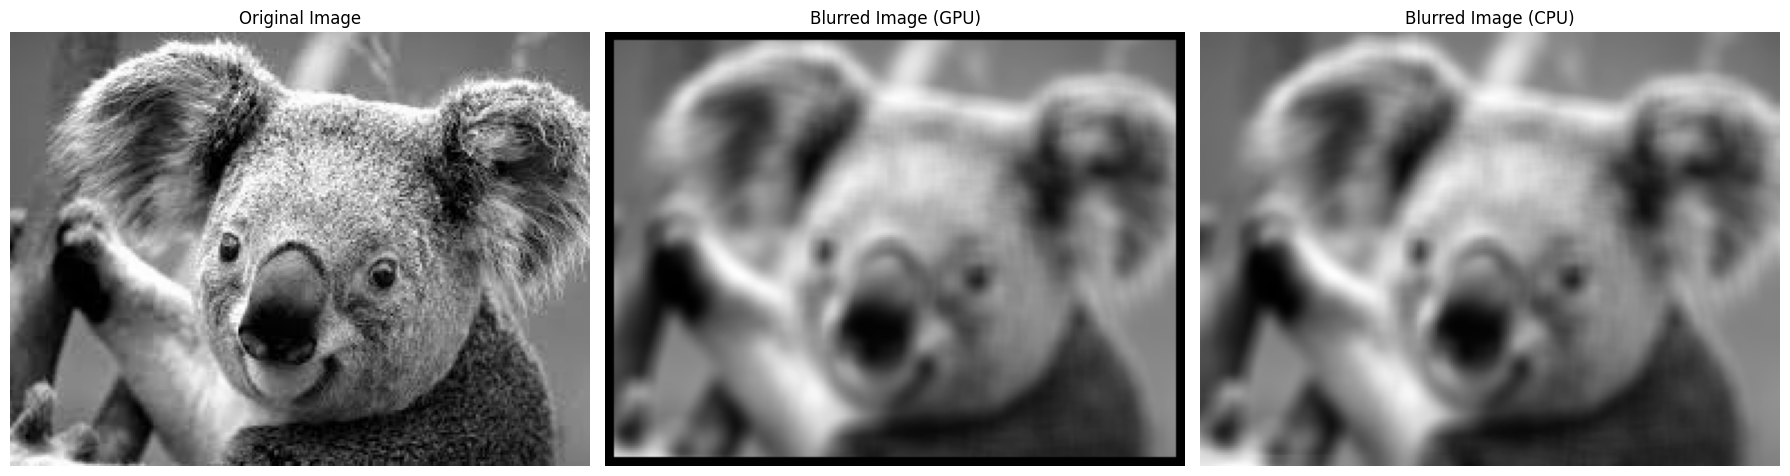

Image Size          : 50246 pixels
GPU Execution Time: 0.7597 seconds
CPU Execution Time: 2.2650 seconds
Outputs match: False
GPU speedup factor: 2.98x
Approximate FLOPS for GPU: 25725952
Approximate FLOPS for CPU: 25725952
GPU Performance: 0.03 GFLOPS
CPU Performance: 0.01 GFLOPS
GPU Memory Usage: 3459.67 MB
CPU Memory Usage: 0.05 MB
GPU Throughput: 66141.25 pixels/second
CPU Throughput: 22183.51 pixels/second
GPU Processing Time per Pixel: 0.0000151192 seconds
CPU Processing Time per Pixel: 0.0000450785 seconds


In [5]:
import numpy as np
import math
from numba import cuda
import numba
from PIL import Image
import matplotlib.pyplot as plt
import time

# Constants for padding and block dimensions
PAD = 4
BLOCK_DIM_X = 16
BLOCK_DIM_Y = 16
SHARED_DIM_X = BLOCK_DIM_X + 2 * PAD
SHARED_DIM_Y = BLOCK_DIM_Y + 2 * PAD

# Load grayscale image
def load_image(image_path):
    img = Image.open(image_path).convert('L')
    return np.array(img)

# CPU blur for validation
def cpu_blur(input_image):
    height, width = input_image.shape
    output_image = np.zeros_like(input_image)
    for y in range(height):
        for x in range(width):
            total = 0
            count = 0
            for j in range(-PAD, PAD + 1):
                for i in range(-PAD, PAD + 1):
                    ny, nx = y + j, x + i
                    if 0 <= ny < height and 0 <= nx < width:
                        total += input_image[ny, nx]
                        count += 1
            output_image[y, x] = total // count
    return output_image

# Shared memory kernel for image blur using Numba CUDA
@cuda.jit
def blur_kernel_shared(input_image, output_image):
    shared_tile = cuda.shared.array(shape=(SHARED_DIM_Y, SHARED_DIM_X), dtype=numba.uint8)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    x, y = cuda.grid(2)
    stride_x, stride_y = cuda.gridsize(2)

    height, width = input_image.shape

    # Copy data to shared memory with halo padding
    for j in range(y, height, stride_y):
        for i in range(x, width, stride_x):
            shared_x = tx + PAD
            shared_y = ty + PAD

            if j < height and i < width:
                shared_tile[shared_y, shared_x] = input_image[j, i]

            # Handle boundary conditions (halos)
            if tx < PAD:
                if i >= PAD:
                    shared_tile[shared_y, shared_x - PAD] = input_image[j, i - PAD]
                if i + BLOCK_DIM_X < width:
                    shared_tile[shared_y, shared_x + BLOCK_DIM_X] = input_image[j, i + BLOCK_DIM_X]

            if ty < PAD:
                if j >= PAD:
                    shared_tile[shared_y - PAD, shared_x] = input_image[j - PAD, i]
                if j + BLOCK_DIM_Y < height:
                    shared_tile[shared_y + BLOCK_DIM_Y, shared_x] = input_image[j + BLOCK_DIM_Y, i]

            # Handle corner boundaries
            if tx < PAD and ty < PAD:
                if i >= PAD and j >= PAD:
                    shared_tile[shared_y - PAD, shared_x - PAD] = input_image[j - PAD, i - PAD]
                if i + BLOCK_DIM_X < width and j >= PAD:
                    shared_tile[shared_y - PAD, shared_x + BLOCK_DIM_X] = input_image[j - PAD, i + BLOCK_DIM_X]
                if i >= PAD and j + BLOCK_DIM_Y < height:
                    shared_tile[shared_y + BLOCK_DIM_Y, shared_x - PAD] = input_image[j + BLOCK_DIM_Y, i - PAD]
                if i + BLOCK_DIM_X < width and j + BLOCK_DIM_Y < height:
                    shared_tile[shared_y + BLOCK_DIM_Y, shared_x + BLOCK_DIM_X] = input_image[j + BLOCK_DIM_Y, i + BLOCK_DIM_X]

            cuda.syncthreads()

            # Apply blur using the kernel
            if PAD <= i < width - PAD and PAD <= j < height - PAD:
                total = 0
                count = 0
                for dy in range(-PAD, PAD + 1):
                    for dx in range(-PAD, PAD + 1):
                        total += shared_tile[shared_y + dy, shared_x + dx]
                        count += 1
                output_image[j, i] = total // count

            cuda.syncthreads()

# Load image
image_path = 'E:\\Intern\\MEGA-MINDS\\Assign 9\\sample_image3.jpg'
image = load_image(image_path)

# Allocate GPU memory for input and output
input_gpu = cuda.to_device(image)
output_gpu = cuda.device_array_like(image)

# Grid/block configuration for CUDA kernel
threads_per_block = (BLOCK_DIM_X, BLOCK_DIM_Y)
blocks_per_grid_x = math.ceil(image.shape[1] / BLOCK_DIM_X)
blocks_per_grid_y = math.ceil(image.shape[0] / BLOCK_DIM_Y)
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# Measure GPU execution time
start_gpu = time.time()
blur_kernel_shared[blocks_per_grid, threads_per_block](input_gpu, output_gpu)
cuda.synchronize()
end_gpu = time.time()
gpu_output = output_gpu.copy_to_host()

# Measure CPU execution time for comparison
start_cpu = time.time()
cpu_output = cpu_blur(image)
end_cpu = time.time()

# Plotting the original, GPU blurred, and CPU blurred images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(image, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

axes[1].imshow(gpu_output, cmap='gray')
axes[1].set_title("Blurred Image (GPU)")
axes[1].axis('off')

axes[2].imshow(cpu_output, cmap='gray')
axes[2].set_title("Blurred Image (CPU)")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Output performance results
gpu_execution_time = end_gpu - start_gpu
cpu_execution_time = end_cpu - start_cpu
print(f"Image Size          : {image.size} pixels")  # Display image size in pixels
print(f"GPU Execution Time: {gpu_execution_time:.4f} seconds")
print(f"CPU Execution Time: {cpu_execution_time:.4f} seconds")
print("Outputs match:", np.allclose(gpu_output, cpu_output))
print("GPU speedup factor: {:.2f}x".format(cpu_execution_time / gpu_execution_time))

# Additional performance results
image_size = image.size  # Total number of pixels in the image (width * height)
flops_gpu = 2 * image_size * (BLOCK_DIM_X * BLOCK_DIM_Y)  # Approximate FLOPS for GPU (each thread performs multiple operations)
flops_cpu = flops_gpu  # Same FLOPS for CPU since both perform the same blur operation

# Calculate and print the theoretical GPU performance (in GFLOPS)
gpu_gflops = flops_gpu / gpu_execution_time / 1e9  # FLOPS per second (converted to GFLOPS)
cpu_gflops = flops_cpu / cpu_execution_time / 1e9  # FLOPS per second (converted to GFLOPS)

# GPU Memory Usage
gpu_memory_usage = cuda.current_context().get_memory_info()[0]  # GPU memory usage (bytes)

# CPU Memory Usage
cpu_memory_usage = image.nbytes  # CPU memory usage (bytes)

# Throughput (data processed per second)
gpu_throughput = image_size / gpu_execution_time  # Pixels per second (GPU)
cpu_throughput = image_size / cpu_execution_time  # Pixels per second (CPU)

# Processing time per pixel
gpu_pixel_time = gpu_execution_time / image_size  # Time per pixel on GPU (seconds)
cpu_pixel_time = cpu_execution_time / image_size  # Time per pixel on CPU (seconds)

# Output all performance results
print(f"Approximate FLOPS for GPU: {flops_gpu}")
print(f"Approximate FLOPS for CPU: {flops_cpu}")
print(f"GPU Performance: {gpu_gflops:.2f} GFLOPS")
print(f"CPU Performance: {cpu_gflops:.2f} GFLOPS")
print(f"GPU Memory Usage: {gpu_memory_usage / 1e6:.2f} MB")
print(f"CPU Memory Usage: {cpu_memory_usage / 1e6:.2f} MB")
print(f"GPU Throughput: {gpu_throughput:.2f} pixels/second")
print(f"CPU Throughput: {cpu_throughput:.2f} pixels/second")
print(f"GPU Processing Time per Pixel: {gpu_pixel_time:.10f} seconds")
print(f"CPU Processing Time per Pixel: {cpu_pixel_time:.10f} seconds")

# Optionally, save the GPU blurred image to a file
output_image_pil = Image.fromarray(gpu_output)
output_image_pil.save("blurred_image_gpu.jpg")


## Problem 3 Histogram kernel from Lab8


 Evaluation Results
Image Size          : 50246 pixels
GPU Execution Time   : 0.281276 seconds
CPU Execution Time   : 0.282211 seconds
Outputs Match        : Yes
GPU Speedup Factor   : 1.00x
GPU Throughput       : 178636.09 operations/sec
CPU Throughput       : 178044.35 operations/sec
GPU FLOPS            : 357272.18 FLOPS
CPU FLOPS            : 356088.69 FLOPS
GPU Memory Bandwidth : 0.000182 GB/s
CPU Memory Bandwidth : 0.000182 GB/s
GPU Memory Usage     : 3459.67 MB
CPU Memory Usage     : 0.05 MB
GPU Processing Time per Pixel: 0.0000055980 seconds
CPU Processing Time per Pixel: 0.0000056166 seconds


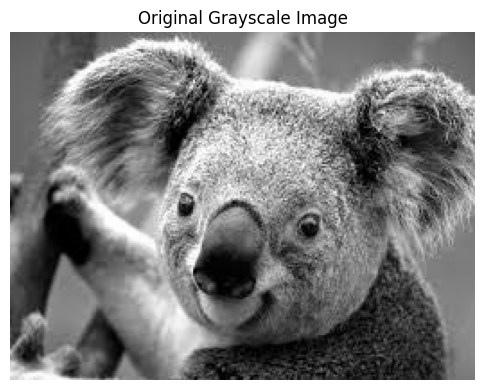

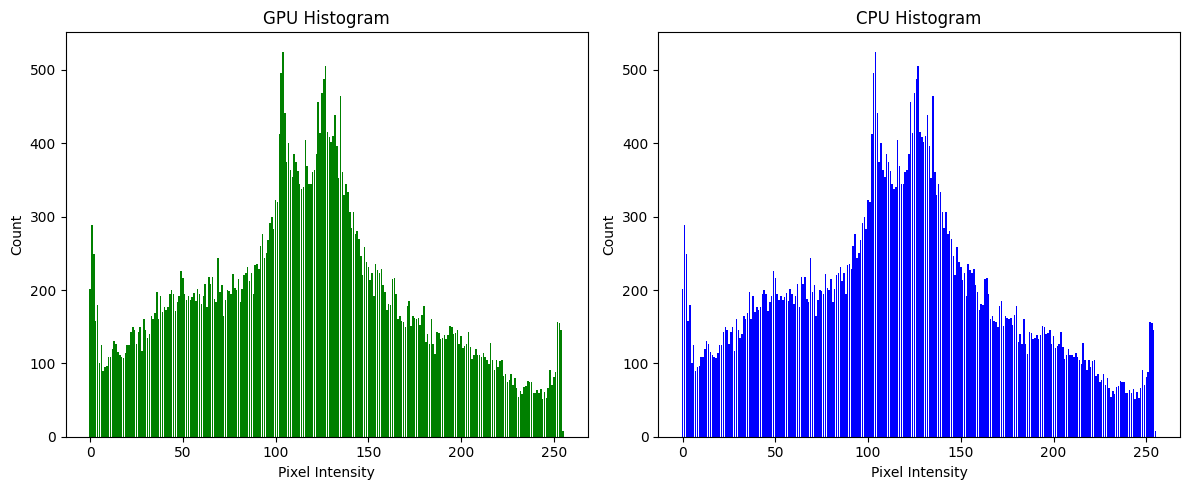

In [6]:
import numpy as np
import math
from numba import cuda
import numba
from PIL import Image
import matplotlib.pyplot as plt
import time

NUM_BINS = 256
THREADS_PER_BLOCK = 256

@cuda.jit
def histogram_kernel_shared(data, histogram):
    shared_hist = cuda.shared.array(shape=NUM_BINS, dtype=numba.int32)

    tx = cuda.threadIdx.x
    idx = cuda.grid(1)
    stride = cuda.gridsize(1)

    for i in range(tx, NUM_BINS, cuda.blockDim.x):
        shared_hist[i] = 0
    cuda.syncthreads()

    for i in range(idx, data.size, stride):
        val = data[i]
        if 0 <= val < NUM_BINS:
            cuda.atomic.add(shared_hist, val, 1)
    cuda.syncthreads()

    for i in range(tx, NUM_BINS, cuda.blockDim.x):
        cuda.atomic.add(histogram, i, shared_hist[i])

def cpu_histogram(data):
    hist = np.zeros(NUM_BINS, dtype=np.int32)
    for val in data:
        if 0 <= val < NUM_BINS:
            hist[val] += 1
    return hist

image_path = 'E:\\Intern\\MEGA-MINDS\\Assign 9\\sample_image3.jpg'

img = Image.open(image_path).convert('L')
data = np.array(img, dtype=np.uint8).flatten()

histogram_gpu = np.zeros(NUM_BINS, dtype=np.int32)

data_gpu = cuda.to_device(data)
histogram_device = cuda.to_device(histogram_gpu)

blocks_per_grid = math.ceil(data.size / THREADS_PER_BLOCK)

start_gpu = time.time()
histogram_kernel_shared[blocks_per_grid, THREADS_PER_BLOCK](data_gpu, histogram_device)
cuda.synchronize()
end_gpu = time.time()

histogram_gpu = histogram_device.copy_to_host()

start_cpu = time.time()
histogram_cpu = cpu_histogram(data)
end_cpu = time.time()

gpu_time = end_gpu - start_gpu
cpu_time = end_cpu - start_cpu
outputs_match = np.array_equal(histogram_gpu, histogram_cpu)
speedup = cpu_time / gpu_time if gpu_time > 0 else float('inf')

total_operations = data.size
gpu_throughput = total_operations / gpu_time
cpu_throughput = total_operations / cpu_time

flops_per_pixel = 2
gpu_flops = flops_per_pixel * total_operations / gpu_time
cpu_flops = flops_per_pixel * total_operations / cpu_time

memory_bandwidth_gpu = (data.nbytes + histogram_gpu.nbytes) / gpu_time / 1e9
memory_bandwidth_cpu = (data.nbytes + histogram_cpu.nbytes) / cpu_time / 1e9

gpu_memory_usage = cuda.current_context().get_memory_info()[0]  # GPU memory usage (bytes)
cpu_memory_usage = data.nbytes + histogram_cpu.nbytes  # CPU memory usage (bytes)

gpu_pixel_time = gpu_time / total_operations  # GPU processing time per pixel (seconds)
cpu_pixel_time = cpu_time / total_operations  # CPU processing time per pixel (seconds)

# Print evaluation results
print("\n Evaluation Results")
print(f"Image Size          : {data.size} pixels")
print(f"GPU Execution Time   : {gpu_time:.6f} seconds")
print(f"CPU Execution Time   : {cpu_time:.6f} seconds")
print(f"Outputs Match        : {'Yes' if outputs_match else 'No'}")
print(f"GPU Speedup Factor   : {speedup:.2f}x")
print(f"GPU Throughput       : {gpu_throughput:.2f} operations/sec")
print(f"CPU Throughput       : {cpu_throughput:.2f} operations/sec")
print(f"GPU FLOPS            : {gpu_flops:.2f} FLOPS")
print(f"CPU FLOPS            : {cpu_flops:.2f} FLOPS")
print(f"GPU Memory Bandwidth : {memory_bandwidth_gpu:.6f} GB/s")
print(f"CPU Memory Bandwidth : {memory_bandwidth_cpu:.6f} GB/s")
print(f"GPU Memory Usage     : {gpu_memory_usage / 1e6:.2f} MB")
print(f"CPU Memory Usage     : {cpu_memory_usage / 1e6:.2f} MB")
print(f"GPU Processing Time per Pixel: {gpu_pixel_time:.10f} seconds")
print(f"CPU Processing Time per Pixel: {cpu_pixel_time:.10f} seconds")

# === Show the original image ===
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title("Original Grayscale Image")
plt.axis('off')
plt.show()

# === Plot histograms ===
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.bar(range(NUM_BINS), histogram_gpu, color='green')
plt.title("GPU Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(range(NUM_BINS), histogram_cpu, color='blue')
plt.title("CPU Histogram")
plt.xlabel('Pixel Intensity')
plt.ylabel('Count')

plt.tight_layout()
plt.show()
